# **문화체육관광부 국립현대미술관 전시회정보**

* https://www.data.go.kr/data/3067477/fileData.do

In [1]:
# !pip install -q konlpy
# !sudo apt-get install curl git
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# !pip install python-opencv
# !pip install wordcloud

In [13]:
import cv2
import datetime
import pprint
import re

import numpy as np
import pandas as pd
import seaborn as sns

from konlpy.tag import Mecab
from matplotlib import pyplot as plt
from pathlib import Path
from wordcloud import WordCloud

In [16]:
class HParams(object):
    def __init__(self):
        self.data_path = Path("data", "exhibitionList_20210830.csv")
        self.img_path = Path("data", "image.png")
        
HPARAMS = HParams()
pprint.PrettyPrinter(indent=4).pprint(vars(HPARAMS))

{   'data_path': PosixPath('data/exhibitionList_20210830.csv'),
    'img_path': PosixPath('data/image.png')}


In [2]:
# plt.rc("font", family="NanumBarunGothic") 
plt.rc("font", family="serif")

## **전시관 위치**

* Folium 대신 Google Maps API 사용

In [8]:
%%html
<iframe src="https://www.google.com/maps/embed?pb=!1m14!1m8!1m3!1d6324.15294289718!2d126.97440810061084!3d37.57681693368814!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x0%3A0xfb70e7c1c785a405!2z6rWt66a97ZiE64yA66-47Iig6rSAIOyEnOyauOq0gA!5e0!3m2!1sko!2skr!4v1630509042676!5m2!1sko!2skr" 
    width="80%" height="600" style="border:0;" allowfullscreen="" loading="lazy"></iframe>

일반적으로 생각하는 미술관의 이미지
* 전시명: 대안적 언어 (아스거 욘)
  - https://www.ktsketch.co.kr/news/articleView.html?idxno=3507

In [9]:
# %%html
# <img src="https://www.ktsketch.co.kr/news/photo/201904/3507_10685_1351.jpg" width="70%" loading="lazy"></img>

국립현대미술관에 전시된 동적인 분위기의 미술관
* 전시명: 우리는 무엇으로 사는가? (하룬 파로키)
  - https://www.mcst.go.kr/kor/s_policy/comm/studentNews/studentNewsView.jsp?pSeq=4929

In [10]:
# %%html
# <img src="https://www.mcst.go.kr/attachFiles/editor/attachFiles/attachFiles/notifyCourt/news/images/000094/Ng==.jpg" width="70%" loading="lazy"></img>

## **Load Data**

* 전시 데이터는 매일 업데이트되며, 2021년 8월 30일자 데이터를 사용

In [23]:
!tree -h

.
├── [4.0K]  data
│   ├── [133K]  exhibitionList_20210830.csv
│   └── [475K]  image.png
├── [2.0M]  exhibition.ipynb
└── [ 183]  README.md

1 directory, 4 files


In [32]:
df = pd.read_csv(HPARAMS.data_path, encoding="cp949", index_col=False)
df.columns = df.columns.str.strip() ## remove whitespace in columns' front/end
df.sample(5)

,전시구분,장소,제목,참여작가,기간,전시실
678,과거전시,과천,박서보 회화40년전,박서보,1991.10.25-1991.11.14,제1전시실
626,과거전시,과천,제13회 대한민국미술대전 2부: 구상계열,NaN,1994.10.01-1994.10.18,NaN
825,과거전시,덕수궁,정규 특별전,정규,1984.03.01-1984.04.30,NaN
347,과거전시,과천,메가시티 네트워크: 한국현대건축 서울,권문성.김영준.김인철.유걸.유석연.이종호.이충기.정기용.조남호.조민석.조병수.주대관...,2009.12.23-2010.03.07,제7 전시실
125,과거전시,레지던시,제 3의 언어,손광주. 진시우. 최 선. 파레틴 오렌리. 에밀리 베이츠. 팀 써즈데이. 엠마 코랄,2017.05.25-2017.06.11,창동레지던시


In [33]:
df.shape

(1083, 6)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   전시구분    1083 non-null   object
 1   장소      1081 non-null   object
 2   제목      1081 non-null   object
 3   참여작가    726 non-null    object
 4   기간      1081 non-null   object
 5   전시실     799 non-null    object
dtypes: object(6)
memory usage: 50.9+ KB


## **결측치 처리**

* 일부 컬럼에서는 행이 밀렸는지 NaN 값이 존재함 → 결측치가 존재하는 행는 Drop

In [35]:
df.isna().sum()

전시구분      0
장소        2
제목        2
참여작가    357
기간        2
전시실     284
dtype: int64

In [36]:
## Dataframe where "장소" == nan
df[df.loc[:, "장소"].isna()]

,전시구분,장소,제목,참여작가,기간,전시실
390,브라질 상파울루 현대미술관(MAM),NaN,NaN,NaN,NaN,NaN
391,아르헨티나 부에노스아이레스 국립미술관(MNBA),NaN,NaN,NaN,NaN,NaN


In [37]:
## Drop 390, 391th items.
df = df[~df.loc[:, "장소"].isna()]
df.isna().sum()

전시구분      0
장소        0
제목        0
참여작가    355
기간        0
전시실     282
dtype: int64

## **전시 구분, 장소에 대한 고유값 확인**

* 전시구분: 현재전시, 예정전시, 과거전시
* 장소: 서울, 덕수궁, 과천, 레지던시, 청주, 어린이미술관 등...
  - 레지던시(Residency): 국내 시각예술 작가들의 창작 여건 활성화를 위해 매년 젊고 유망한 작가들을 선발하여 지원 (만 25세 이상, 약 1년)

In [38]:
df.columns

Index(['전시구분', '장소', '제목', '참여작가', '기간', '전시실'], dtype='object')

In [39]:
df.loc[: ,"전시구분"].unique()

array(['현재전시', '예정전시', '과거전시'], dtype=object)

In [40]:
df.loc[: ,"장소"].unique()

array(['서울', '청주', '덕수궁', '과천', '어린이미술관', '레지던시', '국립현대미술관', '고양레지던시',
       '해외', '기타', '창동레지던시'], dtype=object)

In [41]:
## Excel로 열었을 때 181번째 column에서 줄이 밀려있는 것을 알고있으므로, 데이터를 다시 한 번 확인

## "기간" column이 모두 YYYY.MM.DD-YYYY.MM.DD의 형태인지 확인
##   1. 정규표현식(regex) 이용해서 탐색
##   2. datetime.datetime module 이용하여 올바른 형식인지 확인

condition = "^\\d{4}.\\d{2}.\\d{2}-\\d{4}.\\d{2}.\\d{2}$"
df[~df.loc[:, "기간"].str.contains(condition)]

## 모두 올바른 형태임을 확인

,전시구분,장소,제목,참여작가,기간,전시실


## **새로운 열 추가**

- 기간 → 전시 시작일, 전시 종료일

In [42]:
## 전시 시작일
sp = df.loc[:, "기간"].apply(lambda x: x.split("-")[0]).copy()
##  전시 종료일
ep = df.loc[:, "기간"].apply(lambda x: x.split("-")[-1]).copy()

sp

0       2021.08.24
1       2021.08.20
2       2021.07.21
3       2021.07.13
4       2021.07.08
           ...    
1078    1959.04.24
1079    1958.11.28
1080    1958.11.16
1081    1957.11.21
1082    1956.10.25
Name: 기간, Length: 1081, dtype: object

In [43]:
## 기존의 전시기간은 유지한채 새로운 컬럼 추가
df["시작일"] = pd.to_datetime(sp, format="%Y-%m-%d")
df["종료일"] = pd.to_datetime(ep, format="%Y-%m-%d")
df["전시기간(일)"] = (df["종료일"] - df["시작일"]).apply(lambda x: str(x).split("days")[0].strip()).astype(int)

df.loc[:, ["제목", "기간", "시작일", "종료일", "전시기간(일)"]].sample(5)

,제목,기간,시작일,종료일,전시기간(일)
136,≪미각의 미감≫,2016.12.05-2017.03.19,2016-12-05,2017-03-19,104
447,올해의 작가2004 : 김익영 윤광조,2004.11.06-2004.12.26,2004-11-06,2004-12-26,50
724,제1회 대한민국서예대전,1989.10.20-1989.11.08,1989-10-20,1989-11-08,19
730,원계홍 회고전,1989.07.06-1989.07.25,1989-07-06,1989-07-25,19
785,86 대한민국공예대전,1986.11.07-1986.12.06,1986-11-07,1986-12-06,29


## **연간 전시회 개최 횟수 확인**

In [44]:
## 시작일 기준
years = df.loc[:, "시작일"].dt.year
years

0       2021
1       2021
2       2021
3       2021
4       2021
        ... 
1078    1959
1079    1958
1080    1958
1081    1957
1082    1956
Name: 시작일, Length: 1081, dtype: int64

In [45]:
## Groupby 사용: 2장 '구별 음식점 업종 비교하기' 등 참고
counts = df.groupby(by=years).count().loc[:, ["전시구분"]]
counts = counts.reset_index()
counts.columns = ["전시연도", "전시횟수"]
counts

,전시연도,전시횟수
0,1956,1
1,1957,1
2,1958,2
3,1959,2
4,1960,1
...,...,...
61,2017,27
62,2018,27
63,2019,30
64,2020,27


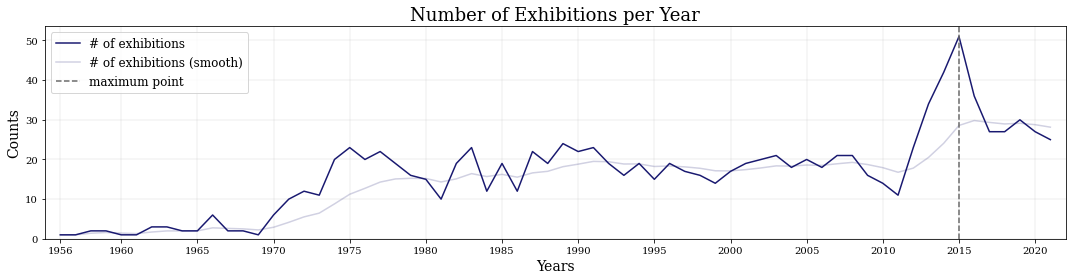

In [46]:
plt.figure(figsize = (15, 4), facecolor="white")

## Plot
plt.plot(counts["전시연도"], counts["전시횟수"], c="midnightblue", label="# of exhibitions")
## Plot smoothing line.
plt.plot(counts["전시연도"], counts["전시횟수"].ewm(5).mean(), c="midnightblue", alpha=.2, label="# of exhibitions (smooth)")
## Draw horizontal lines.
idx = counts.loc[:, "전시횟수"].argmax() ## "전시구분"의 값이 가장 큰 
plt.axvline(counts.loc[idx, "전시연도"], 0., 100, c='dimgrey', ls='--', label="maximum point")
## 가장 전시 횟수가 많은 연도를 x축에 표시
plt.xticks([i for i in range(1960, 2025, 5)] + [idx] + [counts.loc[:, "전시연도"].min()])
## x, y축 구간 설정
plt.xlim([counts.loc[:, "전시연도"].min() - 1, counts.loc[:, "전시연도"].max() + 1])
plt.ylim([0, counts.loc[:, "전시횟수"].max() * 1.05])
## 축 이름
plt.title("Number of Exhibitions per Year", fontsize=18)
plt.xlabel("Years", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.legend(loc="best", fontsize=12)

plt.grid(True, lw=.2)
plt.tight_layout()
plt.show()

## **연간 전시회당 평균 전시 일수 확인**

In [47]:
## 전시 기간이 가장 긴 전시는?
df.iloc[df["전시기간(일)"].argsort()].tail(5)

,전시구분,장소,제목,참여작가,기간,전시실,시작일,종료일,전시기간(일)
152,과거전시,과천,국립현대미술관 과천30년 특별전 <아카이브 프로젝트-기억의 공존>,NaN,2016.07.15-2018.02.25,2원형전시실,2016-07-15,2018-02-25,590
313,과거전시,과천,어린이미술관 Edu-Studio,오창근. 원광연. 애브리웨어. 이배경 등,2012.04.27-2013.12.31,어린이미술관(제 7전시실),2012-04-27,2013-12-31,613
354,과거전시,과천,컬렉션. 미술관을 말하다,박수근. 이중섭 등 200여명,2009.09.29-2011.07.17,제 3.4.6전시실,2009-09-29,2011-07-17,656
15,현재전시,과천,시대를 보는 눈 : 한국근현대미술,250여 명,2020.07.21-2022.07.31,3. 4. 5. 6전시실 및 회랑,2020-07-21,2022-07-31,740
11,현재전시,청주,개방 수장고 개편,NaN,2020.12.03-2026.12.31,개방수장고,2020-12-03,2026-12-31,2219


In [48]:
## 마지막 데이터에 대한 index 값을 구함
last = df.iloc[df["전시기간(일)"].argsort()].tail(1).index
## 해당 index를 가진 행을 drop
df = df.drop(last)
## 잘 제거되었는지 다시 데이터 확인
df.iloc[df["전시기간(일)"].argsort()].tail(5)

,전시구분,장소,제목,참여작가,기간,전시실,시작일,종료일,전시기간(일)
8,현재전시,어린이미술관,너랑 나랑___,김유선. 김지수. 리사박. 서세옥. 이미주. 최호철. 홍승혜. 앤디 워홀,2021.05.04-2022.12.11,NaN,2021-05-04,2022-12-11,586
152,과거전시,과천,국립현대미술관 과천30년 특별전 <아카이브 프로젝트-기억의 공존>,NaN,2016.07.15-2018.02.25,2원형전시실,2016-07-15,2018-02-25,590
313,과거전시,과천,어린이미술관 Edu-Studio,오창근. 원광연. 애브리웨어. 이배경 등,2012.04.27-2013.12.31,어린이미술관(제 7전시실),2012-04-27,2013-12-31,613
354,과거전시,과천,컬렉션. 미술관을 말하다,박수근. 이중섭 등 200여명,2009.09.29-2011.07.17,제 3.4.6전시실,2009-09-29,2011-07-17,656
15,현재전시,과천,시대를 보는 눈 : 한국근현대미술,250여 명,2020.07.21-2022.07.31,3. 4. 5. 6전시실 및 회랑,2020-07-21,2022-07-31,740


In [49]:
tmp = df.loc[:, ["전시기간(일)"]].copy()
tmp["전시연도"] = df["시작일"].dt.year

tmp

,전시기간(일),전시연도
0,61,2021
1,44,2021
2,235,2021
3,131,2021
4,94,2021
...,...,...
1078,19,1959
1079,10,1958
1080,9,1958
1081,13,1957


In [50]:
days = tmp.groupby(by=["전시연도"]).mean()
days = days.reset_index()
days.columns = ["전시연도", "평균전시기간(일)"]

days

,전시연도,평균전시기간(일)
0,1956,7.000000
1,1957,13.000000
2,1958,9.500000
3,1959,12.500000
4,1960,29.000000
...,...,...
61,2017,112.370370
62,2018,146.518519
63,2019,153.266667
64,2020,191.461538


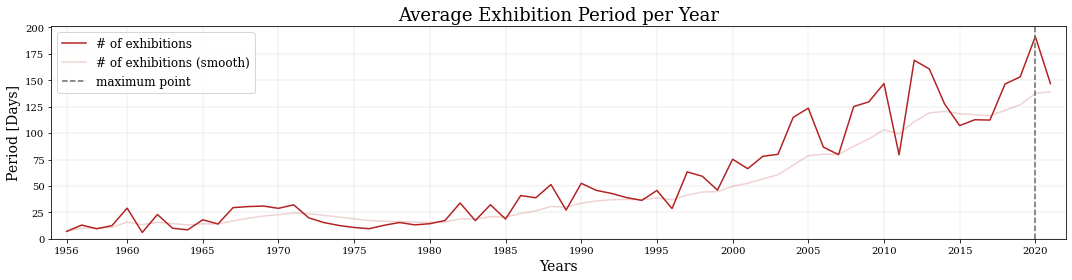

In [51]:
plt.figure(figsize = (15, 4), facecolor="white")

## Plot
plt.plot(days["전시연도"], days["평균전시기간(일)"], c="firebrick", label="# of exhibitions")
## Plot smoothing line.
plt.plot(days["전시연도"], days["평균전시기간(일)"].ewm(5).mean(), c="firebrick", alpha=.2, label="# of exhibitions (smooth)")
## Draw horizontal lines.
idx = days.loc[:, "평균전시기간(일)"].argmax() ## "전시구분"의 값이 가장 큰 
plt.axvline(days.loc[idx, "전시연도"], 0., 100, c='dimgrey', ls='--', label="maximum point")
## 가장 전시 횟수가 많은 연도를 x축에 표시
plt.xticks([i for i in range(1960, 2025, 5)] + [idx] + [days.loc[:, "전시연도"].min()])
## x, y축 구간 설정
plt.xlim([days.loc[:, "전시연도"].min() - 1, days.loc[:, "전시연도"].max() + 1])
plt.ylim([0, days.loc[:, "평균전시기간(일)"].max() * 1.05])
## 축 이름
plt.title("Average Exhibition Period per Year", fontsize=18)
plt.xlabel("Years", fontsize=14)
plt.ylabel("Period [Days]", fontsize=14)
plt.legend(loc="best", fontsize=12)

plt.grid(True, lw=.2)
plt.tight_layout()
plt.show()

## **2000년도 이후 국립현대미술관 '서울관'의 데이터로 한정**

* 약간의 전처리 포함

In [52]:
## 2000년도 이후의 전시
recent_df = df.loc[:, "시작일"].dt.year > 2000
## 국립현대미술관 서울관에서 진행한 전시
seoul_df = df.loc[:, "장소"] == "서울"

## 2000년도 이후의 전시 AND 국립현대미술관 서울관에서 진행한 전시만 추출
recent_seoul_df = df.loc[recent_df & seoul_df].copy()
recent_seoul_df = recent_seoul_df.reset_index(drop=True)

## 불필요한 열 삭제: "전시구분", "장소", "기간"
recent_seoul_df = recent_seoul_df.drop(["전시구분", "장소", "기간"], axis=1)

recent_seoul_df.head(5)

,제목,참여작가,전시실,시작일,종료일,전시기간(일)
0,우리 집에서. 워치 앤 칠,건축농장(최장원).?구동희.?김희천.?마크 살바투스.?사룻 수파수티벡.?시린 세노....,6전시실,2021-08-24,2021-10-24,61
1,DMZ 극장,수르야. 정연두,8전시실,2021-08-20,2021-10-03,44
2,MMCA 이건희컬렉션 특별전: 한국미술명작,권옥연. 권진규. 김경. 김기창. 김은호. 김종영. 김종태. 김중현. 김환기. 김흥...,1전시실,2021-07-21,2022-03-13,235
3,정상화,정상화,3.4전시실,2021-05-22,2021-09-26,127
4,《움직임을 만드는 움직임》,로테 라이니거. 오스카 피싱거. 렌 라이. 카렐 제만. 노먼 매클래런,7전시실 및 미디어랩,2021-04-23,2021-09-26,156


In [53]:
recent_seoul_df.shape

(109, 6)

In [54]:
## 1개의 '참여작가' 셀이 비어있음을 확인
recent_seoul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   제목       109 non-null    object        
 1   참여작가     108 non-null    object        
 2   전시실      109 non-null    object        
 3   시작일      109 non-null    datetime64[ns]
 4   종료일      109 non-null    datetime64[ns]
 5   전시기간(일)  109 non-null    int64         
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 5.2+ KB


In [55]:
## 링크: http://www.projecthashtag.net/
recent_seoul_df.loc[recent_seoul_df.loc[:, "참여작가"].isna(), :]

,제목,참여작가,전시실,시작일,종료일,전시기간(일)
6,프로젝트 해시태그 2021,NaN,8전시실,2021-11-02,2022-02-06,96


In [56]:
is_nan = recent_seoul_df.loc[:, "참여작가"].isna()
recent_seoul_df = recent_seoul_df.loc[~is_nan, :]

In [57]:
recent_seoul_df.shape

(108, 6)

## **워드클라우드**

* KoNLPy의 kkma 라이브러리 사용
  - https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/

In [58]:
## "제목" 칸의 모든 텍스트 추출

words = " ".join(recent_seoul_df.loc[:, "제목"])
words[:1000]

'우리 집에서. 워치 앤 칠 DMZ 극장 MMCA 이건희컬렉션 특별전: 한국미술명작 정상화 《움직임을 만드는 움직임》 아이 웨이웨이 올해의 작가상 2021  MMCA 현대차 시리즈 2021: 문경원 & 전준호 ? 미지에서 온 소식. 자유의 마을 재난과 치유 황재형: 회천回天 국립현대미술관 미술은행 소장품 특별전 「돌아온 미래 Super Nature-Hypnagogia」 올해의 작가상 2020 이승택 - 거꾸로. 비미술 MMCA 현대차 시리즈 2020: 양혜규―O2 & H2O 모두를 위한 미술관. 개를 위한 미술관 프로젝트 해시태그 2020 낯선 전쟁 2020 아시아 기획전 《또 다른 가족을 찾아서》 MMCA 소장품 하이라이트 2020+ 수평의 축 MMCA 현대차 시리즈 2019: 박찬경 ? 모임 Gathering 올해의 작가상 2019 국립현대미술관 50주년 기념전 《이경성을 회고하다》 국립현대미술관 개관 50주년 기념전 《광장: 미술과 사회 1900-2019》3부. 2019 김순기: 게으른 구름 떠도는 영상들의 연대기 박서보: 지칠 줄 모르는 수행자 안톤 비도클: 모두를 위한 불멸 대안적 언어 ? 아스거 욘. 사회운동가로서의 예술가 불온한 데이터  마르셀 뒤샹  《미장센: 이미지의 역사》  《하룬 파로키 ? 우리는 무엇으로 사는가?》 《MMCA 현대차 시리즈 2018: 최정화 ? 꽃.숲》 올해의 작가상 2018 윤형근  뉴미디어 아카이브 《알레고리. 사물들. 기억술》 예술과 기술의 실험(E.A.T.): 또 다른 시작 아크람 자타리: 사진에 저항하다 2018  아시아 기획전 《당신은 몰랐던 이야기》 국립현대미술관 현대차시리즈 2017 : 임흥순 <우리를 갈라놓는 것들>  요나스 메카스: 찰나. 힐긋. 돌아보다 올해의 작가상 2017 종이와 콘크리트: 한국 현대건축 운동 1987-1997 젊은 건축가 프로그램 2017 크지슈토프 보디츠코: 기구. 기념비. 프로젝션 불확정성의 원리 신소장품 2013~16 삼라만상: 김환기에서 양푸둥까지 ≪미각의 미감≫ <식물도감:

In [59]:
## Text cleaning: 영어, 한글 제외하고는 전부 제거 (숫자 포함) + 공백 2칸 이상 제거

clean_words = re.sub("[^a-zA-Z가-힣]", " ", words)
clean_words = re.sub("\s+", " ", clean_words) 
clean_words[:1000]

'우리 집에서 워치 앤 칠 DMZ 극장 MMCA 이건희컬렉션 특별전 한국미술명작 정상화 움직임을 만드는 움직임 아이 웨이웨이 올해의 작가상 MMCA 현대차 시리즈 문경원 전준호 미지에서 온 소식 자유의 마을 재난과 치유 황재형 회천 국립현대미술관 미술은행 소장품 특별전 돌아온 미래 Super Nature Hypnagogia 올해의 작가상 이승택 거꾸로 비미술 MMCA 현대차 시리즈 양혜규 O H O 모두를 위한 미술관 개를 위한 미술관 프로젝트 해시태그 낯선 전쟁 아시아 기획전 또 다른 가족을 찾아서 MMCA 소장품 하이라이트 수평의 축 MMCA 현대차 시리즈 박찬경 모임 Gathering 올해의 작가상 국립현대미술관 주년 기념전 이경성을 회고하다 국립현대미술관 개관 주년 기념전 광장 미술과 사회 부 김순기 게으른 구름 떠도는 영상들의 연대기 박서보 지칠 줄 모르는 수행자 안톤 비도클 모두를 위한 불멸 대안적 언어 아스거 욘 사회운동가로서의 예술가 불온한 데이터 마르셀 뒤샹 미장센 이미지의 역사 하룬 파로키 우리는 무엇으로 사는가 MMCA 현대차 시리즈 최정화 꽃 숲 올해의 작가상 윤형근 뉴미디어 아카이브 알레고리 사물들 기억술 예술과 기술의 실험 E A T 또 다른 시작 아크람 자타리 사진에 저항하다 아시아 기획전 당신은 몰랐던 이야기 국립현대미술관 현대차시리즈 임흥순 우리를 갈라놓는 것들 요나스 메카스 찰나 힐긋 돌아보다 올해의 작가상 종이와 콘크리트 한국 현대건축 운동 젊은 건축가 프로그램 크지슈토프 보디츠코 기구 기념비 프로젝션 불확정성의 원리 신소장품 삼라만상 김환기에서 양푸둥까지 미각의 미감 식물도감 시적 증거와 플로라 MMCA 현대차 l 뮤지엄 페스티벌 마당 대한항공 박스 프로젝트 양지앙 그룹 서예 가장 원시적인 힘의 교류 보이드 올해의 작가상 공예공방 공예가 되기까지 다원예술프로젝트 국립현대미술관 x 국립현대무용단 퍼포먼스 예기치 않은 국립현대미술관 현대차 시리즈 김수자 마음의 기하학 MMCA 싱글채널 비디오 컬렉션 시적 모험 젊은 건축가 프로그

In [60]:
## 자연어처리 분야에서 일반적으로 사용하는 형태소 분석기 적용: KoNLPy.mecab

mecab = Mecab()

noun_words = mecab.nouns(words)
noun_words = " ".join(noun_words)
noun_words[:1000]

'우리 집 워치 앤 극장 이건희 컬렉션 특별 전 한국 미술 명작 정상 움직임 움직임 아이 올해 작가 현대차 시리즈 문경원 전준호 미지 소식 자유 마을 재난 치유 황재 회천 回天 국립 현대 미술관 미술 은행 소장품 특별 전 미래 올해 작가 이승택 미술 현대차 시리즈 양혜규 모두 미술관 개 미술관 프로젝트 해시 태그 전쟁 아시아 기획 전 가족 소장품 하이라이트 수평 축 현대차 시리즈 박찬경 모임 올해 작가 국립 현대 미술관 주년 기념 전 이경성 회고 국립 현대 미술관 개관 주년 기념 전 광장 미술 사회 부 김순기 구름 영상 연대기 박서보 줄 수행자 안톤 비 모두 불멸 대안 언어 아스거 욘 사회 운동가 예술가 데이터 마르셀 뒤샹 미장센 이미지 역사 하룬 파로키 우리 무엇 현대차 시리즈 최정화 꽃 숲 올해 작가 윤형근 뉴 미디어 아카이브 알레고리 사물 기억술 예술 기술 실험 시작 아크람 자 타리 사진 저항 아시아 기획 전 당신 이야기 국립 현대 미술관 현대차 시리즈 임흥순 우리 것 요나스 메카스 찰나 올해 작가 종이 콘크리트 한국 현대 건축 운동 건축가 프로그램 크지슈토프 보디 코 기구 기념비 프로 젝 션 확정 원리 소장품 삼라만상 김환기 양푸 둥 미각 미감 식물도감 시 증거 플로라 현대차 뮤지엄 페스티벌 마당 대한항공 박스 프로젝트 양지 앙 그룹 서예 원시 힘 교류 보이드 올해 작가 공예 공방 공예 다원 예술 프로젝트 국립 현대 미술관 국립 현대 무용단 퍼포먼스 예기 국립 현대 미술관 현대차 시리즈 김수자 마음 기하학 채널 비디오 컬렉션 시 모험 건축가 프로그램 예술가 문서 예술 타이포그래피 협업 공 사 년 이후 한국 현대 미술 사진 망상 지구 에코 시스템 질 바비에 윌리엄 켄트 리지 필립 가렐 절망 정원 조덕현 아카이브 대한항공 박스 프로젝트 율리어스 포프 창동 레지 시 입주 보고서 임흥순 장윤성 진달래 기증 작품 특별 전 서세옥 호 국제 교류 전 뉴 로맨스 국립 현대 미술관 현대차 시리즈 안규철 사랑 나라 향 올해 작가 시민 광복 년 흐름 소란 현대 카드 컬처 

In [64]:
## 국립현대미술관 폰트와 최대한 유사한 폰트 설치
##   - 미술관 폰트: https://www.mmca.go.kr/about/miLogo.do

# !apt-get install fonts-nanum* -qq
!ls /usr/share/fonts/truetype/nanum/

NanumBarunGothicBold.ttf	NanumMyeongjoBold.ttf
NanumBarunGothicLight.ttf	NanumMyeongjoEcoBold.ttf
NanumBarunGothic.ttf		NanumMyeongjoEcoExtraBold.ttf
NanumBarunGothicUltraLight.ttf	NanumMyeongjoEco.ttf
NanumBarunpenB.ttf		NanumMyeongjoExtraBold.ttf
NanumBarunpenR.ttf		NanumMyeongjo.ttf
NanumBrush.ttf			NanumPen.ttf
NanumGothicBold.ttf		NanumSquareB.ttf
NanumGothicCoding-Bold.ttf	NanumSquareEB.ttf
NanumGothicCoding.ttf		NanumSquareL.ttf
NanumGothicEcoBold.ttf		NanumSquareRoundB.ttf
NanumGothicEcoExtraBold.ttf	NanumSquareRoundEB.ttf
NanumGothicEco.ttf		NanumSquareRoundL.ttf
NanumGothicExtraBold.ttf	NanumSquareRoundR.ttf
NanumGothicLight.ttf		NanumSquareR.ttf
NanumGothic.ttf


In [94]:
## Seaborn Palette: https://seaborn.pydata.org/tutorial/color_palettes.html

def wordcloud(data, width=1200, height=500, colormap=None, mask_path=None, factor=0.015):
    if mask_path:
        mask = cv2.imread(str(HPARAMS.img_path))
        mask = np.where(mask >= 1, 255, 0)
    else:
        mask = None
    
    word_draw = WordCloud(
        font_path = r"/usr/share/fonts/truetype/nanum/NanumSquareB.ttf",
        # stopwords = ["운동기구", "개소", "외종"],
        background_color="white",
        width=width, 
        height=height,
        colormap=colormap,
        # colormap=sns.color_palette("dark:#CD5C5C", as_cmap=True),
        mask=mask,
    )
    word_draw.generate(data)

    if mask_path == None:
        plt.figure(figsize = (width * factor, height * factor))
        plt.imshow(word_draw)
        plt.axis("off")
    else:
        plt.figure(figsize = (width * factor * 2, height * factor))
        
        plt.subplot(1, 2, 1)
        plt.imshow(mask)
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(word_draw)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

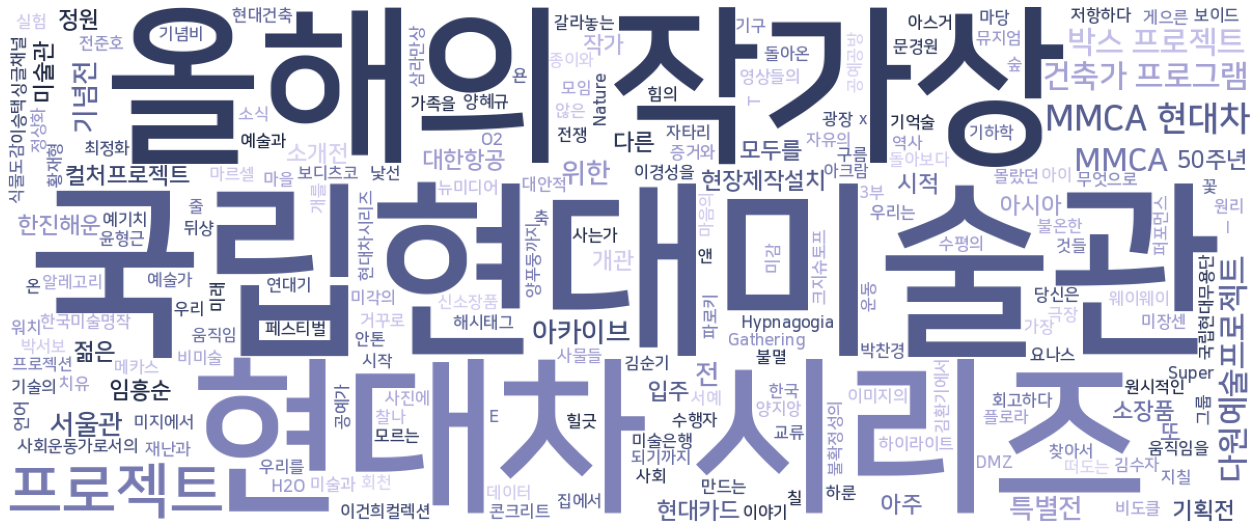

In [95]:
## Original Words
colormap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
wordcloud(words, colormap=colormap)

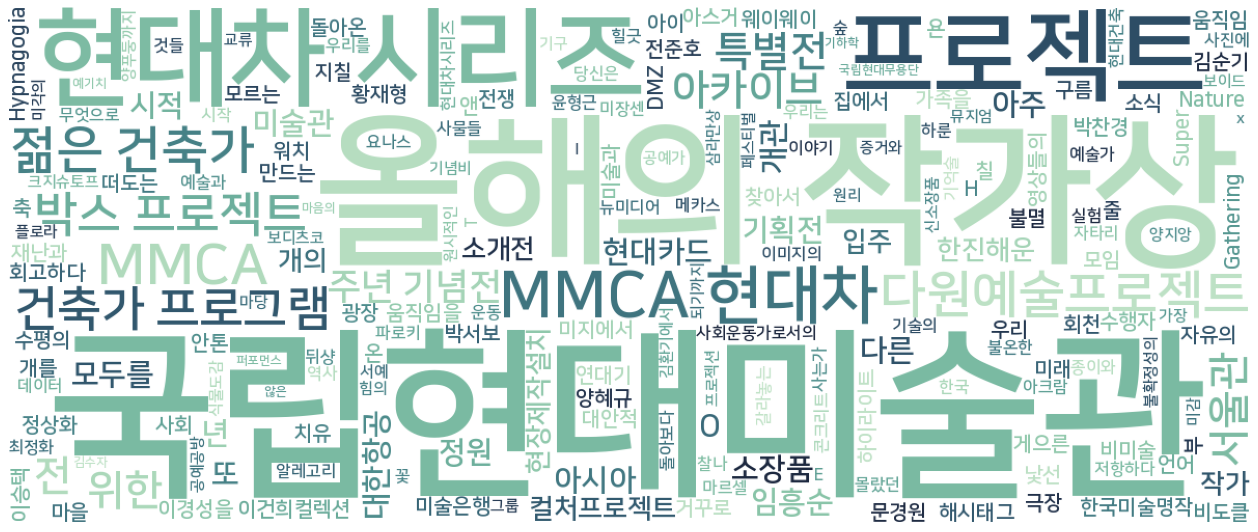

In [96]:
## Clean (alphabet + korean) words.
colormap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
wordcloud(clean_words, colormap=colormap)

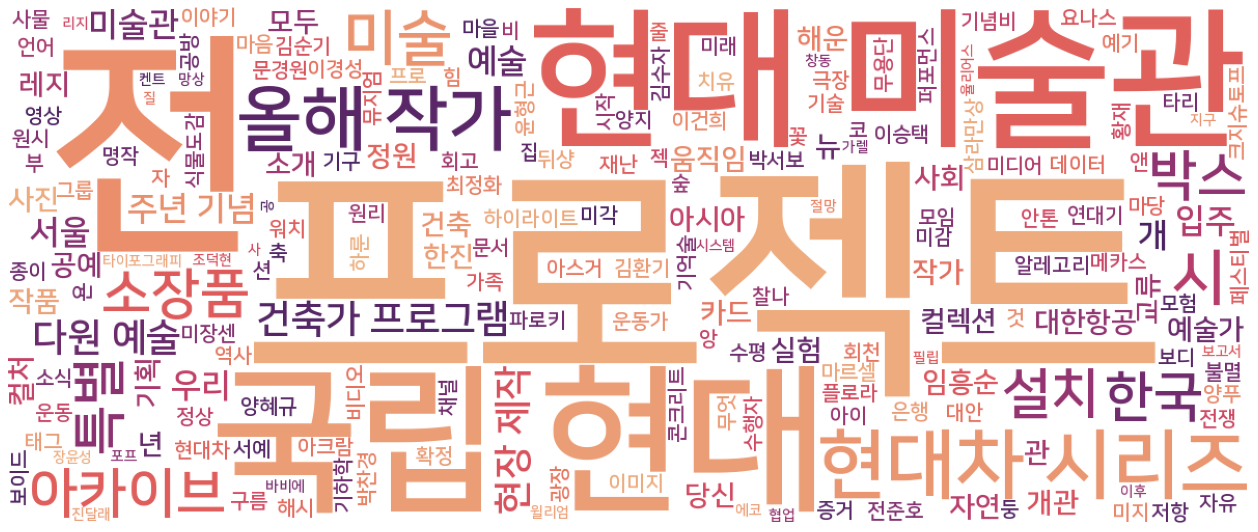

In [97]:
## Only Noun words. (also exclude alphabet)
colormap = sns.color_palette("flare", as_cmap=True)
wordcloud(noun_words, colormap=colormap)

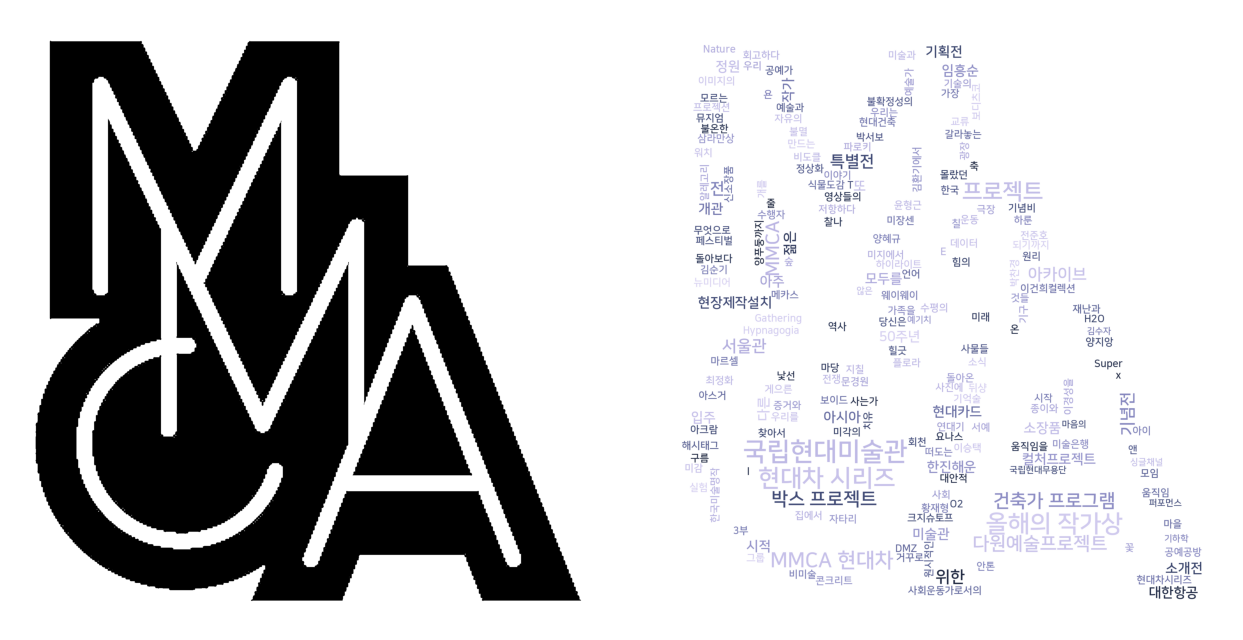

In [99]:
## Mask (background image) 지정된 word cloud.
colormap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
wordcloud(words, height=600, width=600, colormap=colormap, mask_path=HPARAMS.img_path)